# 1월 15일 이상이 발생한 엠씨후디스와 엘트리 컨테이너의 데이터를 사용하여 언제 MSE 값이 0.6 이상이 되는지 확인해보기

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

In [4]:
df = pd.read_csv('../data/carrier_reefer_data_01_to_08_and_12.csv')

In [14]:
# 문자열을 datetime으로 변경
import datetime

df['when_created'] = df['when_created'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

# 엠씨후디스(RDMU5219631)의 DEFROST 데이터 추출

In [79]:
RDMU5219631 = df.loc[df['reefer_id'] == 'RDMU5219631'].reset_index(drop=True)

In [80]:
# 1월 15일까지의 데이터만 추출
RDMU5219631_to_0115 = RDMU5219631.loc[(RDMU5219631['when_created'].dt.month == 1) & (RDMU5219631['when_created'].dt.day <= 15)]

# 엘트리(TRIU8617244)의 데이터 추출

In [20]:
TRIU8617244 = df.loc[df['reefer_id'] == 'TRIU8617244'].reset_index(drop=True)

In [81]:
# 1월 15일까지의 데이터만 추출
TRIU8617244_to_0115 = TRIU8617244.loc[(TRIU8617244['when_created'].dt.month == 1) & (TRIU8617244['when_created'].dt.day <= 15)]

In [34]:
def pop_sequence_number(num_list):
    """
    DEFROST가 발생한 인덱스를 뽑아내는 함수입니다.

    Inputs
    ----------
    num_list: DEFROST가 발생한 인덱스 번호(1차원 리스트)

    Return
    ------
    packet: DEFROST가 발생한 인덱스 번호 묶음(2차원 리스트)
    """
    packet = []
    tmp = []

    v = num_list.pop(0)
    tmp.append(v)

    while (len(num_list) > 0):
        vv = num_list.pop(0)
        if v+1 == vv:
            tmp.append(vv)
            v = vv
        else:
            packet.append(tmp)
            tmp = []
            tmp.append(vv)
            v = vv
    
    packet.append(tmp)
    return packet

In [35]:
defrost_idx_per_reefer = {}

# 컨테이너별 DEFROST가 발생한 인덱스 추출
for reefer_id in ['RDMU5219631', 'TRIU8617244']:
    aa = df.loc[(df['reefer_id'] == reefer_id)].reset_index(drop=True)
    defrost_idx_per_reefer[reefer_id] = pop_sequence_number(list(aa.loc[aa['operating_mode_str'] == "DEFROST"].index))

In [36]:
# DEFROST포함 24개의 로그를 만들 수 있는 것만 추출

from tqdm import tqdm

for reefer_id in ['RDMU5219631', 'TRIU8617244']:
    idx_bundle = defrost_idx_per_reefer[reefer_id]
    drop_idx_list = []
    for idx_list in tqdm(idx_bundle):
        standard_length = (24 - len(idx_list)) // 2
        if (idx_list[0] - standard_length < 0) or (idx_list[-1] + standard_length > df.loc[df['reefer_id'] == reefer_id].shape[0]):
            print(reefer_id, idx_list)
            drop_idx_list.append(idx_list)
    for idx in drop_idx_list:
        idx_bundle.remove(idx)

  2%|▏         | 4/263 [00:00<00:08, 28.85it/s]

RDMU5219631 [8]


100%|██████████| 275/275 [00:12<00:00, 22.14it/s]


In [39]:
# DEFROST가 발생한 인덱스의 길이를 24로 고정
for reefer_id, idx_bundle in defrost_idx_per_reefer.items():
    for i, idx_list in enumerate(idx_bundle):
        if len(idx_list) != 0:
            standard_length = (24 - len(idx_list)) // 2
            start = list(range(idx_list[0]-standard_length, idx_list[0]))
            end = list(range(idx_list[-1]+1, idx_list[-1]+standard_length+1))
            start.extend(idx_list)
            start.extend(end)
            if len(start) == 23:
                start.append(start[-1]+1)
            defrost_idx_per_reefer[reefer_id][i] = start

[27]
[46, 47]
[66, 67]
[105, 106]
[150, 151]
[190, 191]
[234, 235]
[278, 279]
[345, 346]
[399]
[442]
[484]
[530]
[571]
[609, 610]
[647, 648]
[687]
[725, 726]
[766, 767]
[806]
[880, 881]
[954, 955]
[1029, 1030]
[1121, 1122]
[1207, 1208]
[1299, 1300]
[1399, 1400]
[1477]
[1562, 1563]
[1640]
[1715, 1716]
[1720]
[1727]
[1804, 1805]
[1879]
[1886, 1887]
[1893]
[1969]
[1976, 1977]
[1986]
[1995]
[2005, 2006]
[2021]
[2046, 2047]
[2121, 2122]
[2198, 2199]
[2276]
[2355]
[2433, 2434]
[2508]
[2594]
[2669, 2670]
[2754]
[2829, 2830]
[2904, 2905]
[2983, 2984]
[3061, 3062]
[3142, 3143]
[3217]
[3304]
[3385]
[3470, 3471]
[3585, 3586]
[3660, 3661]
[3741, 3742]
[3818]
[3896, 3897]
[3972, 3973]
[4046, 4047]
[4123, 4124]
[4198]
[4272, 4273]
[4347, 4348]
[4423, 4424]
[4497, 4498]
[4572, 4573]
[4584, 4585, 4586]
[4985, 4986]
[5074, 5075]
[5102]
[5268, 5269, 5270]
[5340, 5341]
[5485, 5486, 5487]
[5734, 5735, 5736]
[5848, 5849, 5850]
[5934, 5935, 5936]
[5964, 5965, 5966, 5967]
[6038, 6039, 6040]
[6199, 6200, 6201

In [44]:
from pyts.approximation import PiecewiseAggregateApproximation

concat_list_at = []
concat_list_rat = []
concat_list_sat = []

idx_list_all = []

for reefer_id, idx_bundle in defrost_idx_per_reefer.items():
    for idx_list in tqdm(idx_bundle):
        if len(idx_list) != 0 and len(idx_list) > 13:
            df_tmp = df.loc[df['reefer_id'] == reefer_id].reset_index(drop=True)
            df_tmp = df_tmp.fillna(method='ffill')
            df_for_gaf = df_tmp.loc[idx_list].reset_index(drop=True)

            idx_list_all.append([idx_list, reefer_id])

            concat_list_at.append(df_for_gaf[['ambient_temperature']].T)
            concat_list_rat.append(df_for_gaf[['return_air_temperature']].T)
            concat_list_sat.append(df_for_gaf[['supply_air_temperature']].T)

100%|██████████| 275/275 [00:15<00:00, 17.48it/s]


In [45]:
len(idx_list_all), len(pd.concat(concat_list_at))

(537, 537)

In [46]:
from pyts.image import GramianAngularField

gasf = GramianAngularField(method='summation')
X_gasf_at = gasf.fit_transform(pd.concat(concat_list_at))
X_gasf_rat = gasf.fit_transform(pd.concat(concat_list_rat))
X_gasf_sat = gasf.fit_transform(pd.concat(concat_list_sat))


gadf = GramianAngularField(method='difference')
X_gadf_at = gadf.fit_transform(pd.concat(concat_list_at))
X_gadf_rat = gadf.fit_transform(pd.concat(concat_list_rat))
X_gadf_sat = gadf.fit_transform(pd.concat(concat_list_sat))

In [47]:
image_data_dict = {
    "gasf_at":[X_gasf_at.tolist(), idx_list_all], 
    "gasf_rat":[X_gasf_rat.tolist(), idx_list_all],
    "gasf_sat":[X_gasf_sat.tolist(), idx_list_all],
    "gadf_at":[X_gadf_at.tolist(), idx_list_all],
    "gadf_rat":[X_gadf_rat.tolist(), idx_list_all],
    "gadf_sat":[X_gadf_sat.tolist(), idx_list_all]
}

In [53]:
test_dict = {}

for key in image_data_dict.keys():
    data = image_data_dict[key]

    test = []
    for i, j in zip(data[0], data[1]):
        test.append((torch.FloatTensor([i]), j))
    test = tuple(test)

    test_dict[key] = test

In [55]:
test_dict.keys()

dict_keys(['gasf_at', 'gasf_rat', 'gasf_sat', 'gadf_at', 'gadf_rat', 'gadf_sat'])

In [60]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1), # batch x 16 x 24 x 24
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1), # batch x 32 x 24 x 24
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1), # batch x 64 x 24 x 24
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2) # batch x 64 x 12 x 12
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1), # batch x 128 x 12 x 12
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1), # batch x 256 x 6 x 6
                        nn.ReLU()
        )

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1), # batch x 128 x 12 x 12
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1), # batch x 64 x 12 x 12
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.tran_cnn_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1), # batch x 16 x 12 x 12
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1), # batch x 1 x 24 x 24
                        nn.ReLU()
        )
            
            
    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)

        return output

In [62]:
model_dict = {
    'gasf_at':torch.load("./cae_gasf_at_50.pt"), 
    'gasf_rat':torch.load("./cae_gasf_rat_50.pt"), 
    'gasf_sat':torch.load("./cae_gasf_sat_50.pt"), 
    'gadf_at':torch.load("./cae_gadf_at_50.pt"), 
    'gadf_rat':torch.load("./cae_gadf_rat_50.pt"), 
    'gadf_sat':torch.load("./cae_gadf_sat_50.pt")
}

In [63]:
def test(test, model):
    test_loss_log = []
    model.eval()
    loss_func = nn.MSELoss()

    with torch.no_grad():
        for data in tqdm(test):
            image = data[0].unsqueeze(0)
            output = model(image)
            loss = loss_func(output, image)
            test_loss_log.append([loss.item(), data[1]])
        return test_loss_log

In [64]:
test_loss_log_dict = {}

for key, val in test_dict.items():
    test_loss_log_dict[key] = test(val, model_dict[key])

100%|██████████| 537/537 [00:01<00:00, 517.73it/s]


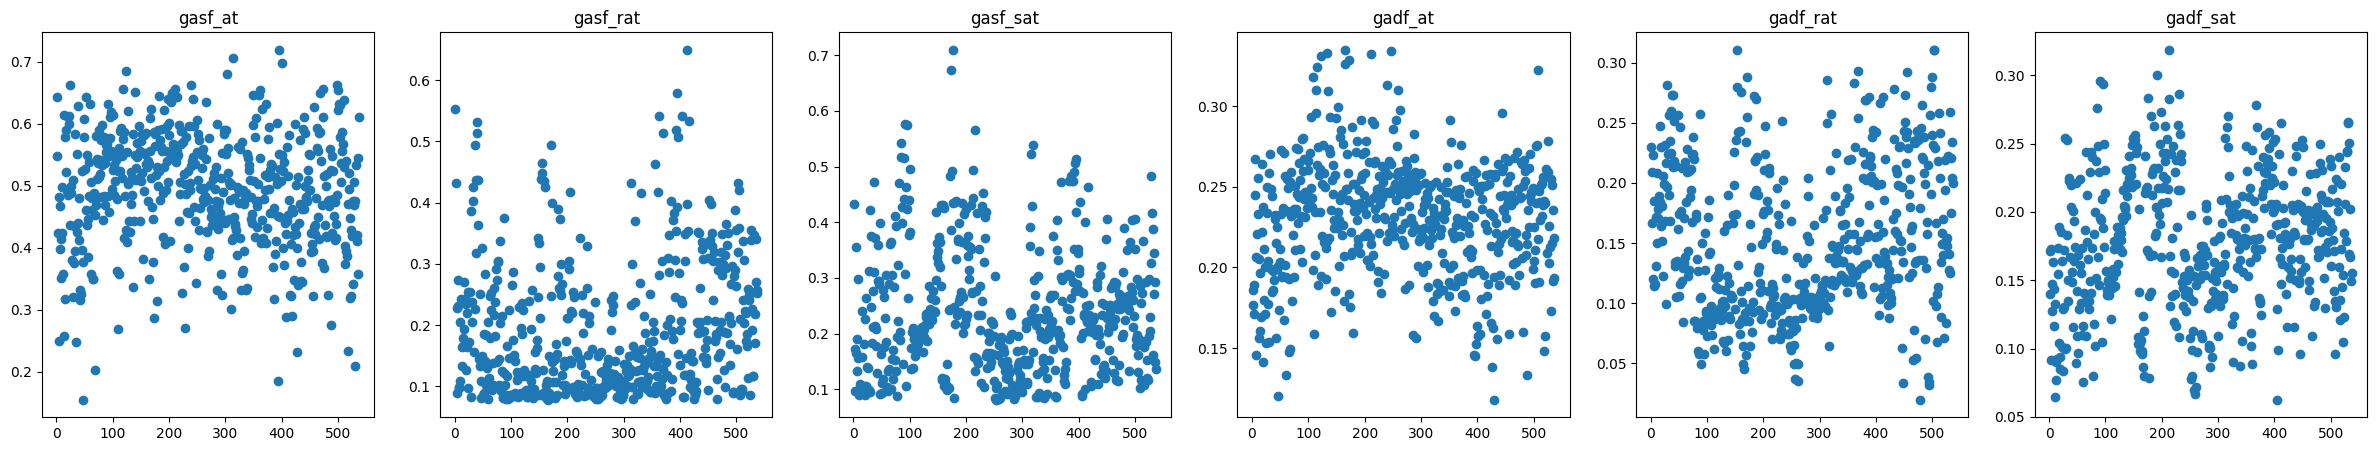

In [66]:
i = 1
plt.rcParams['figure.figsize'] = (30, 5)
for key, val in test_loss_log_dict.items():
    test_loss_log = [x[0] for x in val]
    plt.subplot(1,6,i)
    plt.scatter(x=range(1, len(test_loss_log)+1), y=test_loss_log)
    plt.title(key)
    i += 1

In [67]:
final_test_data_dict = {}

for key, val in test_dict.items():
    tmp_dict = {}
    for i in range(len(val)):
          tmp_dict[i] = [val[i][0].tolist(), test_loss_log_dict[key][i]]
    final_test_data_dict[key] = tmp_dict

In [68]:
for feature in final_test_data_dict.keys():
    loss = []
    word = "공급온도"
    for key, val in final_test_data_dict[feature].items():
        loss.append(val[1][0])

    if feature[:4] == "gasf":
        if feature[5:] == "at":
            word = "외부온도"
        elif feature[5:] == "rat":
            word = "순환온도"
        print(f"GASF방식으로 전처리한 {word}의 테스트셋 MSE 평균: {np.mean(loss):.4f}")

    if feature[:4] == "gadf":
        if feature[5:] == "at":
            word = "외부온도"
        elif feature[5:] == "rat":
            word = "순환온도"
        print(f"GADF방식으로 전처리한 {word}의 테스트셋 MSE 평균: {np.mean(loss):.4f}")

GASF방식으로 전처리한 외부온도의 테스트셋 MSE 평균: 0.4927
GASF방식으로 전처리한 순환온도의 테스트셋 MSE 평균: 0.1914
GASF방식으로 전처리한 공급온도의 테스트셋 MSE 평균: 0.2376
GADF방식으로 전처리한 외부온도의 테스트셋 MSE 평균: 0.2305
GADF방식으로 전처리한 순환온도의 테스트셋 MSE 평균: 0.1511
GADF방식으로 전처리한 공급온도의 테스트셋 MSE 평균: 0.1782


In [70]:
loss_gadf = []

for key in list(final_test_data_dict.keys())[3:]:
    loss = [x[1][0] for key, x in final_test_data_dict[key].items()]
    idx = [x[1][1][0] for key, x in final_test_data_dict[key].items()]
    reefer = [x[1][1][1] for key, x in final_test_data_dict[key].items()]

    loss_gadf.append(np.array(loss))

In [71]:
loss_sum = list(loss_gadf[0] + loss_gadf[1] + loss_gadf[2])

In [72]:
loss_idx_reefer_id = pd.DataFrame({"loss":loss_sum, "index_list":idx, "reefer_id":reefer})

In [73]:
len(loss_idx_reefer_id)

537

In [255]:
bb = loss_idx_reefer_id.loc[loss_idx_reefer_id['reefer_id'] == 'TRIU8617244'].reset_index(drop=True)

In [256]:
bb

,loss,index_list,reefer_id
0,0.459487,"[96, 97, 98, 99, 100, 101, 102, 103, 104, 105,...",TRIU8617244
1,0.498093,"[244, 245, 246, 247, 248, 249, 250, 251, 252, ...",TRIU8617244
2,0.492335,"[462, 463, 464, 465, 466, 467, 468, 469, 470, ...",TRIU8617244
3,0.482194,"[610, 611, 612, 613, 614, 615, 616, 617, 618, ...",TRIU8617244
4,0.526746,"[758, 759, 760, 761, 762, 763, 764, 765, 766, ...",TRIU8617244
...,...,...,...
270,0.676516,"[17668, 17669, 17670, 17671, 17672, 17673, 176...",TRIU8617244
271,0.623017,"[17677, 17678, 17679, 17680, 17681, 17682, 176...",TRIU8617244
272,0.628169,"[17689, 17690, 17691, 17692, 17693, 17694, 176...",TRIU8617244
273,0.572093,"[17723, 17724, 17725, 17726, 17727, 17728, 177...",TRIU8617244


In [253]:
aa = loss_idx_reefer_id.loc[(loss_idx_reefer_id['reefer_id'] == 'RDMU5219631')]

In [254]:
aa

,loss,index_list,reefer_id
0,0.578336,"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...",RDMU5219631
1,0.534909,"[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 4...",RDMU5219631
2,0.447730,"[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...",RDMU5219631
3,0.463821,"[94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 1...",RDMU5219631
4,0.615166,"[139, 140, 141, 142, 143, 144, 145, 146, 147, ...",RDMU5219631
...,...,...,...
257,0.460289,"[19217, 19218, 19219, 19220, 19221, 19222, 192...",RDMU5219631
258,0.404978,"[19540, 19541, 19542, 19543, 19544, 19545, 195...",RDMU5219631
259,0.519827,"[19630, 19631, 19632, 19633, 19634, 19635, 196...",RDMU5219631
260,0.445750,"[19805, 19806, 19807, 19808, 19809, 19810, 198...",RDMU5219631


In [177]:
idx_list = []

for i in range(len(aa)):
    tmp = RDMU5219631.loc[aa.iloc[i]['index_list']]
    for idx, j in enumerate(tmp['when_created']):
        if j.month == 12:
            idx_list.append(i)
            break

In [181]:
aa.loc[idx_list]

,loss,index_list,reefer_id
249,0.454610,"[18306, 18307, 18308, 18309, 18310, 18311, 183...",RDMU5219631
250,0.402839,"[18401, 18402, 18403, 18404, 18405, 18406, 184...",RDMU5219631
251,0.532378,"[18486, 18487, 18488, 18489, 18490, 18491, 184...",RDMU5219631
252,0.395444,"[18559, 18560, 18561, 18562, 18563, 18564, 185...",RDMU5219631
253,0.397193,"[18637, 18638, 18639, 18640, 18641, 18642, 186...",RDMU5219631
254,0.454055,"[18760, 18761, 18762, 18763, 18764, 18765, 187...",RDMU5219631
255,0.413506,"[18894, 18895, 18896, 18897, 18898, 18899, 189...",RDMU5219631
256,0.430162,"[18931, 18932, 18933, 18934, 18935, 18936, 189...",RDMU5219631
257,0.460289,"[19217, 19218, 19219, 19220, 19221, 19222, 192...",RDMU5219631
258,0.404978,"[19540, 19541, 19542, 19543, 19544, 19545, 195...",RDMU5219631


In [231]:
time_list = []

for i in range(len(aa.loc[idx_list])):
    time = RDMU5219631.loc[aa.loc[idx_list].iloc[i]['index_list']].loc[RDMU5219631.loc[aa.loc[idx_list].iloc[i]['index_list']]['operating_mode_str'] == 'DEFROST', 'when_created'].mean()
    if len(str(time.hour)) == 1:
        hour = f"0{time.hour}" 
    time_list.append(f"{time.date()} {hour}h")


In [232]:
aaa = aa.loc[idx_list]

In [233]:
aaa['when_created'] = time_list

In [234]:
aaa = aaa.reset_index(drop=True)

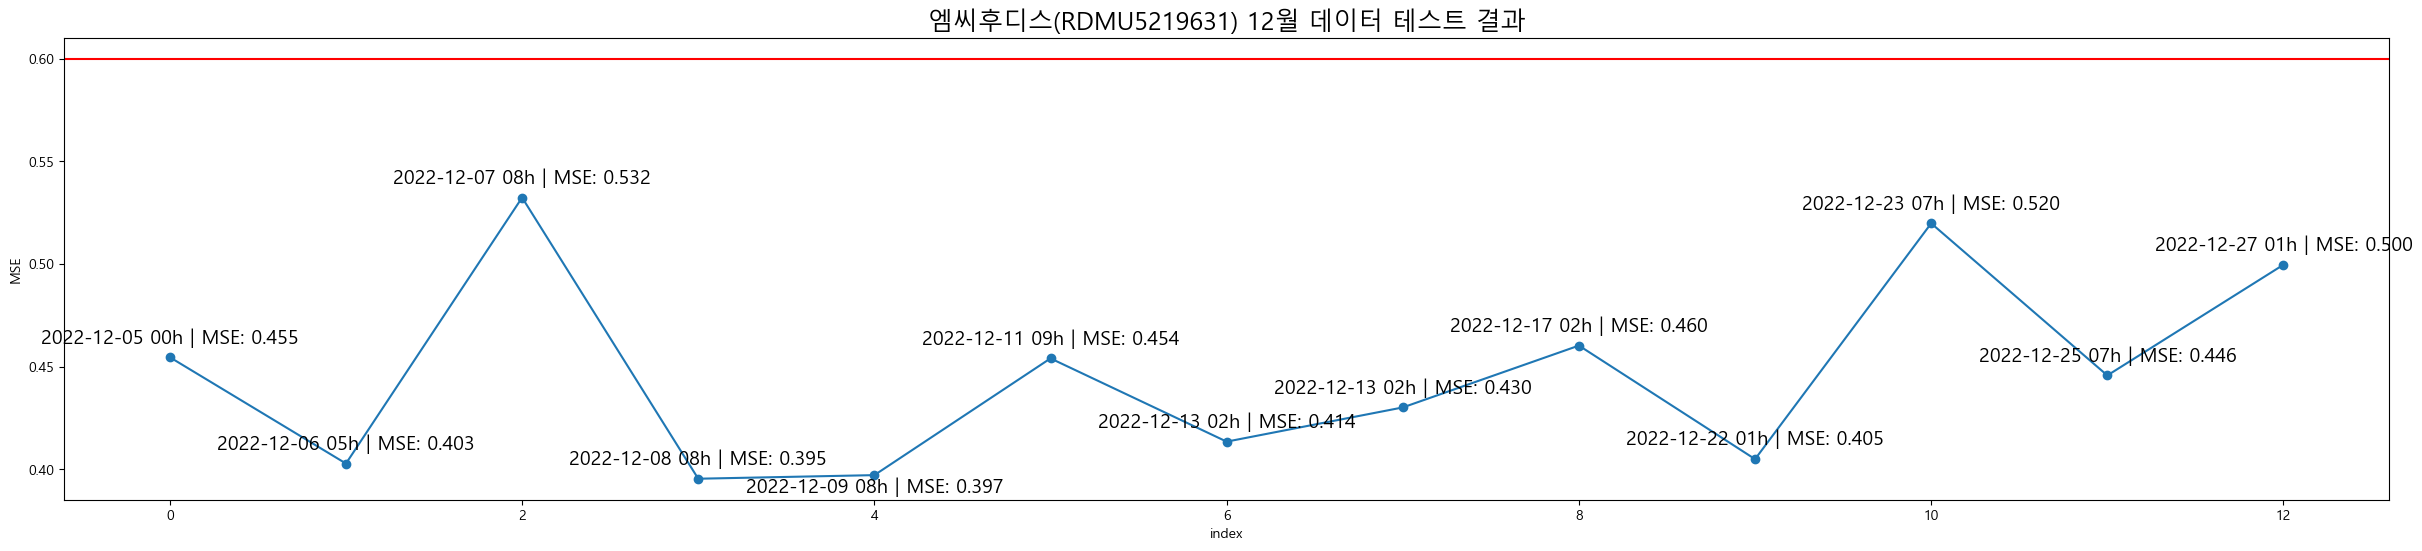

In [245]:
plt.rcParams['figure.figsize'] = (30, 6)
plt.plot(aaa['loss'], 'o-')

for x, y in zip(range(len(aaa)), aaa['loss'].values):
    label = f"{time_list[x]} | MSE: {y:.3f}"
    xytext = (0, 10)
    if x == 4:
        xytext = (0, -13)
    plt.annotate(label,
    (x, y),
    textcoords="offset points",
    xytext=xytext,
    fontsize=14,
    ha="center")

plt.axhline(0.6, color='r')
plt.title("엠씨후디스(RDMU5219631) 12월 데이터 테스트 결과", size=18)
plt.ylabel("MSE")
plt.xlabel("index")
plt.show()

In [257]:
idx_list = []

for i in range(len(bb)):
    tmp = TRIU8617244.loc[bb.iloc[i]['index_list']]
    for idx, j in enumerate(tmp['when_created']):
        if j.month == 12:
            idx_list.append(i)
            break

In [258]:
bb.loc[idx_list]

,loss,index_list,reefer_id
167,0.419331,"[15587, 15588, 15589, 15590, 15591, 15592, 155...",TRIU8617244
168,0.632719,"[15627, 15628, 15629, 15630, 15631, 15632, 156...",TRIU8617244
169,0.764064,"[15648, 15649, 15650, 15651, 15652, 15653, 156...",TRIU8617244
170,0.665955,"[15656, 15657, 15658, 15659, 15660, 15661, 156...",TRIU8617244
171,0.567389,"[15692, 15693, 15694, 15695, 15696, 15697, 156...",TRIU8617244
...,...,...,...
270,0.676516,"[17668, 17669, 17670, 17671, 17672, 17673, 176...",TRIU8617244
271,0.623017,"[17677, 17678, 17679, 17680, 17681, 17682, 176...",TRIU8617244
272,0.628169,"[17689, 17690, 17691, 17692, 17693, 17694, 176...",TRIU8617244
273,0.572093,"[17723, 17724, 17725, 17726, 17727, 17728, 177...",TRIU8617244


In [264]:
time_list = []

for i in range(len(bb.loc[idx_list])):
    time = TRIU8617244.loc[bb.loc[idx_list].iloc[i]['index_list']].loc[TRIU8617244.loc[bb.loc[idx_list].iloc[i]['index_list']]['operating_mode_str'] == 'DEFROST', 'when_created'].mean()
    if len(str(time.hour)) == 1:
        hour = f"0{time.hour}" 
    time_list.append(f"{time.date()} {hour}h")


In [265]:
bbb = bb.loc[idx_list]

In [266]:
bbb['when_created'] = time_list

In [267]:
bbb = bbb.reset_index(drop=True)

In [272]:
for i in range(0, 108, 10):
    print(i)

0
10
20
30
40
50
60
70
80
90
100


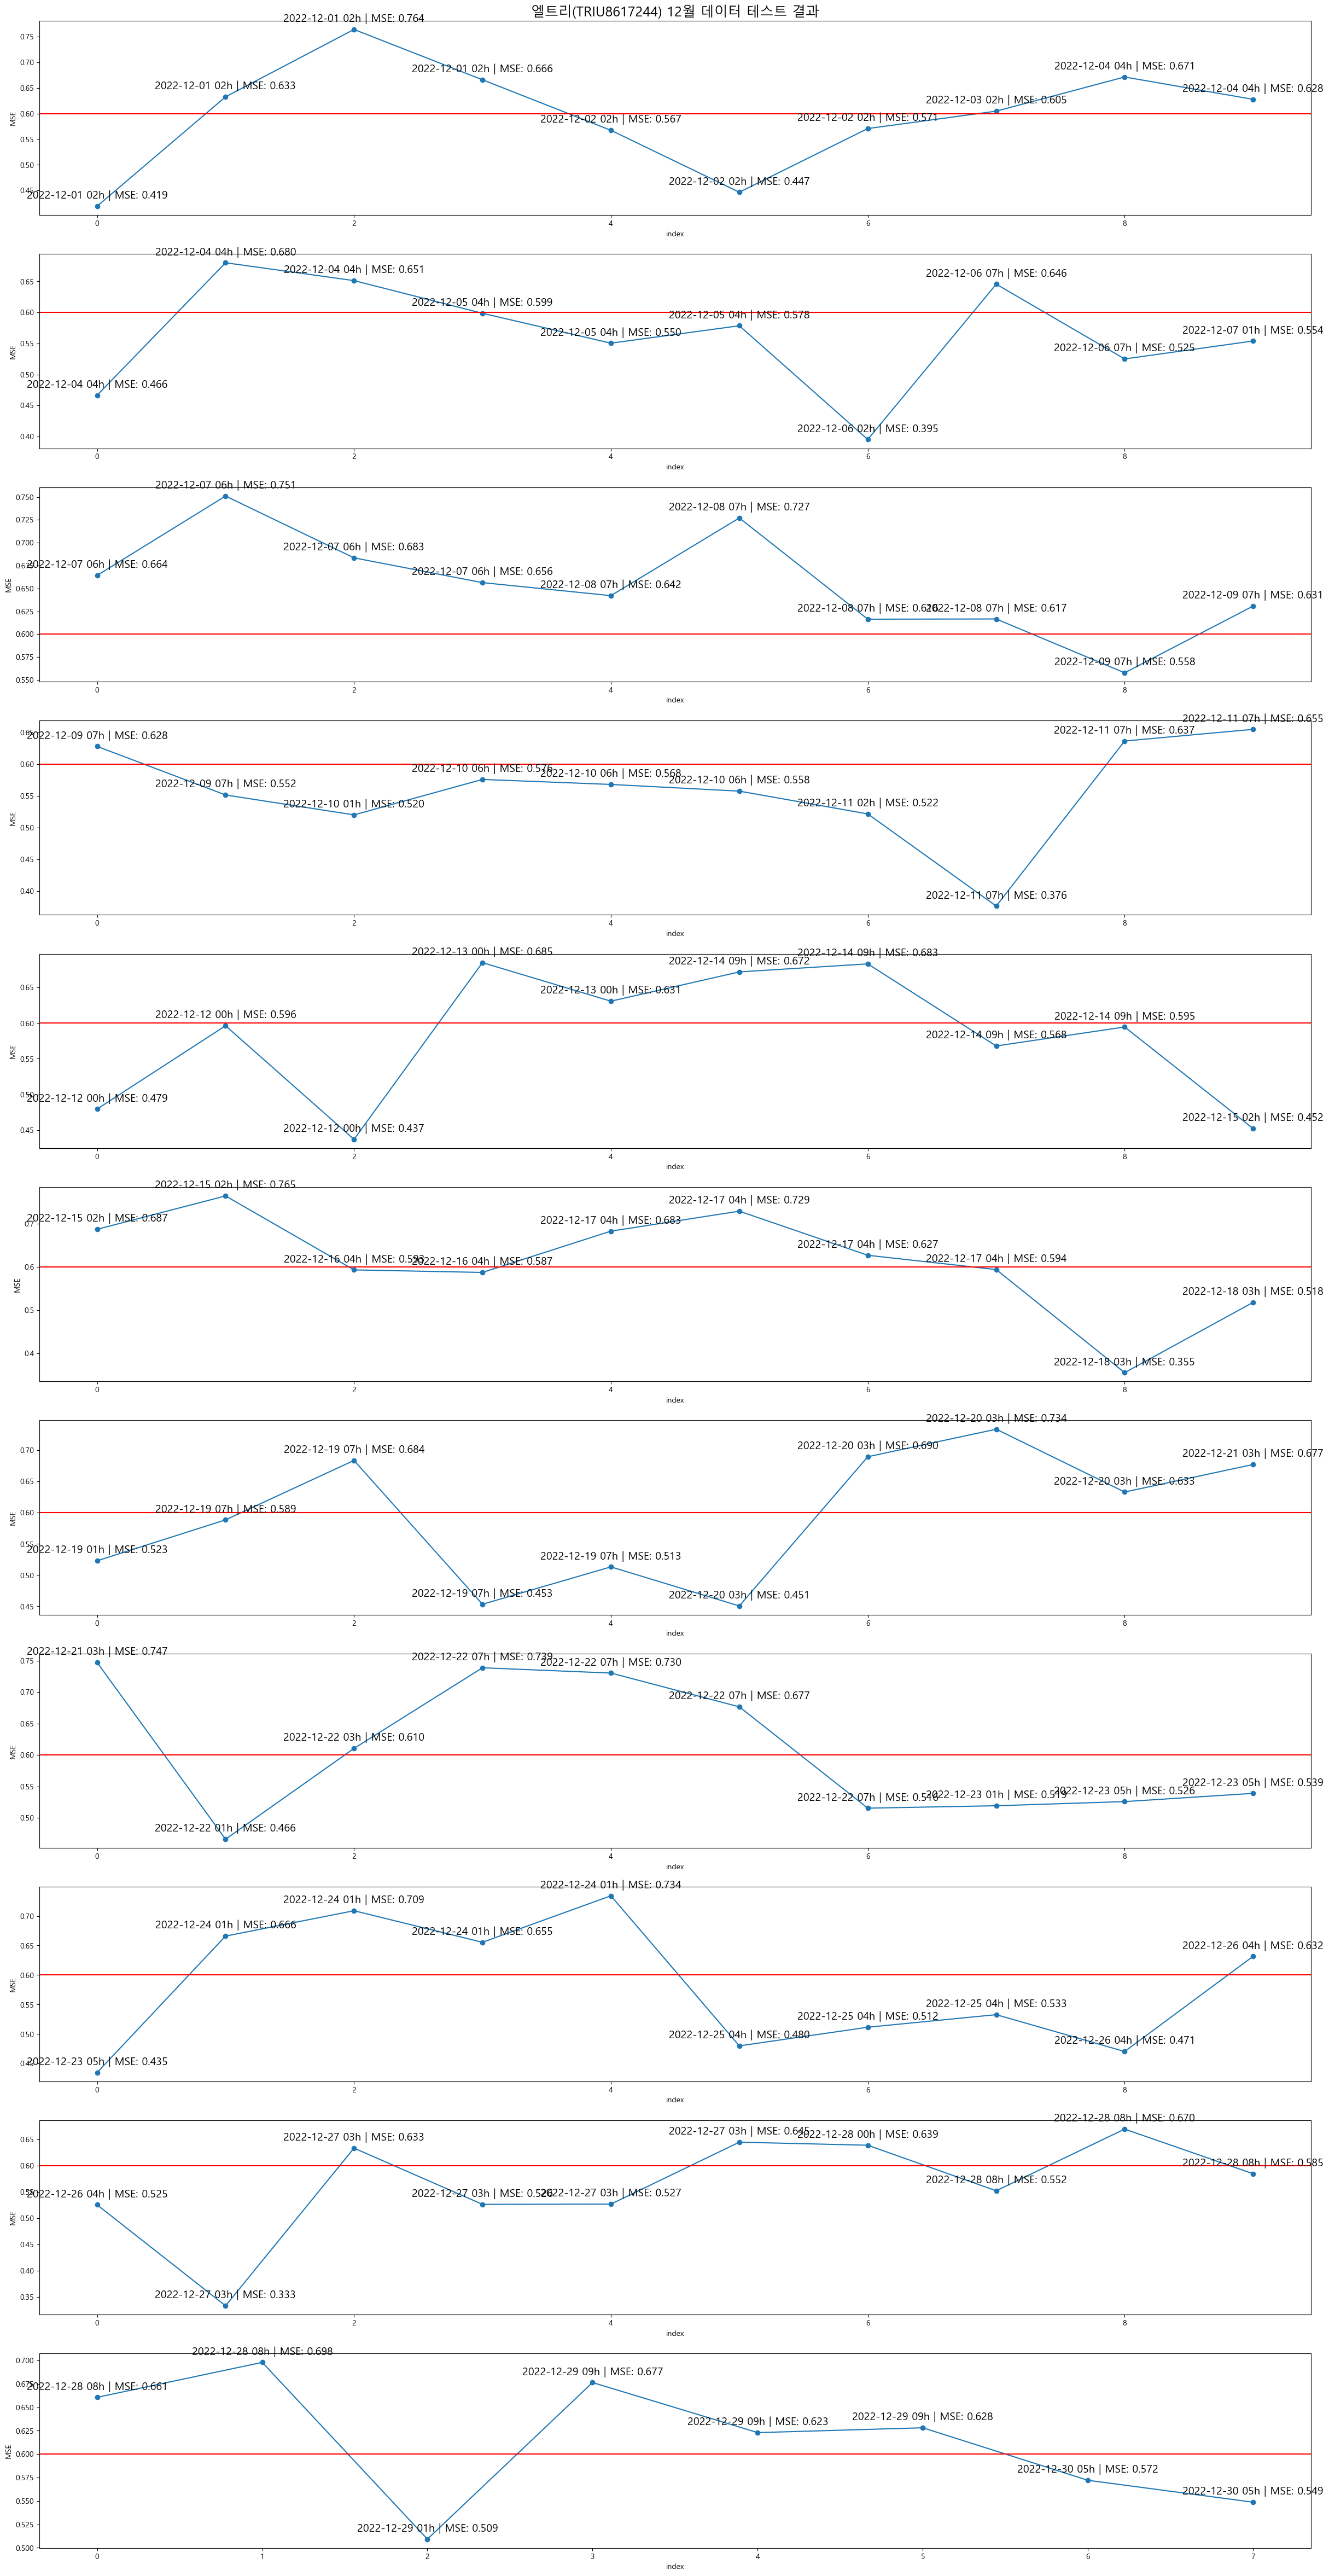

In [287]:
plt.rcParams['figure.figsize'] = (30, 60)
for idx, i in enumerate(range(0, 108, 10)):
    j = i+10
    if i == 100:
        j = 109
    plt.subplot(11, 1, idx+1)
    plt.plot(bbb['loss'].iloc[i:j].reset_index(drop=True), 'o-')
    for x, y in zip(range(j), bbb['loss'].iloc[i:j].values):
        label = f"{time_list[x+i]} | MSE: {y:.3f}"
        xytext = (0, 10)
        plt.annotate(label,
        (x, y),
        textcoords="offset points",
        xytext=xytext,
        fontsize=14,
        ha="center")

    plt.axhline(0.6, color='r')
    if idx == 0:
        plt.title("엘트리(TRIU8617244) 12월 데이터 테스트 결과", size=18)
    plt.ylabel("MSE")
    plt.xlabel("index")
plt.show()

In [289]:
bbb.loc[bbb['loss'] >= 0.6]

,loss,index_list,reefer_id,when_created
1,0.632719,"[15627, 15628, 15629, 15630, 15631, 15632, 156...",TRIU8617244,2022-12-01 02h
2,0.764064,"[15648, 15649, 15650, 15651, 15652, 15653, 156...",TRIU8617244,2022-12-01 02h
3,0.665955,"[15656, 15657, 15658, 15659, 15660, 15661, 156...",TRIU8617244,2022-12-01 02h
7,0.604750,"[15750, 15751, 15752, 15753, 15754, 15755, 157...",TRIU8617244,2022-12-03 02h
8,0.671365,"[15783, 15784, 15785, 15786, 15787, 15788, 157...",TRIU8617244,2022-12-04 04h
9,0.627781,"[15790, 15791, 15792, 15793, 15794, 15795, 157...",TRIU8617244,2022-12-04 04h
11,0.680029,"[15841, 15842, 15843, 15844, 15845, 15846, 158...",TRIU8617244,2022-12-04 04h
12,0.651264,"[15850, 15851, 15852, 15853, 15854, 15855, 158...",TRIU8617244,2022-12-04 04h
17,0.645531,"[15957, 15958, 15959, 15960, 15961, 15962, 159...",TRIU8617244,2022-12-06 07h
20,0.664319,"[16027, 16028, 16029, 16030, 16031, 16032, 160...",TRIU8617244,2022-12-07 06h
